In [1]:
import pandas as pd
import numpy as np
import os
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

In [112]:
clients = pd.read_csv('./data/clients.csv')
products = pd.read_csv('./data/products.csv')
stocks = pd.read_csv('./data/stocks.csv')
stores = pd.read_csv('./data/stores.csv')
transactions = pd.read_csv('./data/transactions.csv')

In [120]:
print('clients: ', clients.columns)
print('products: ', products.columns)
print('stocks: ',stocks.columns)
print('stores: ',stores.columns)
print('transactions: ', transactions.columns)

clients:  Index(['ClientID', 'ClientSegment', 'ClientCountry', 'ClientOptINEmail',
       'ClientOptINPhone', 'ClientGender', 'Age'],
      dtype='object')
products:  Index(['ProductID', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe'], dtype='object')
stocks:  Index(['StoreCountry', 'ProductID', 'Quantity'], dtype='object')
stores:  Index(['StoreID', 'StoreCountry'], dtype='object')
transactions:  Index(['ClientID', 'ProductID', 'SaleTransactionDate', 'StoreID', 'Quantity',
       'SalesNetAmountEuro'],
      dtype='object')


In [4]:
transactions.head()

,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99


In [5]:
transactions['SaleTransactionDate'] = transactions['SaleTransactionDate'].astype(str).str[:10]
transactions['SaleTransactionDate'] = pd.to_datetime(transactions['SaleTransactionDate'])

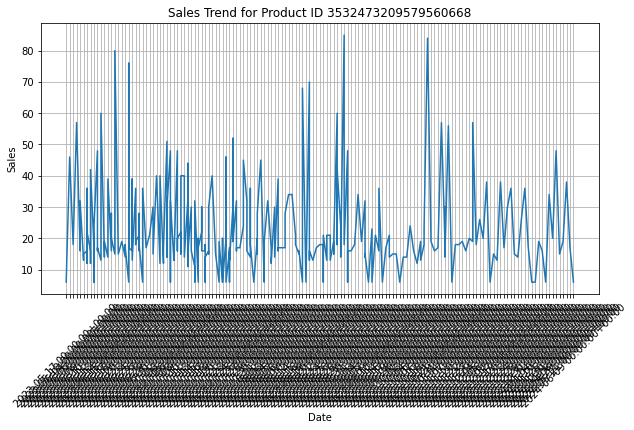

In [118]:
product_ID = 3532473209579560668
prods = transactions[transactions['ProductID']==product_ID]
prods = prods.sort_values(by='SaleTransactionDate')

plt.figure(figsize=(10, 5))
plt.plot(prods['SaleTransactionDate'], prods['SalesNetAmountEuro'], linestyle='-')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Sales Trend for Product ID {product_ID}')
plt.xticks(rotation=45)
plt.grid()

# Show plot
plt.show()

## Transaction Clustering (Same Client, Same date, different products)

In [7]:
grouped_df = transactions.groupby(['ClientID', 'SaleTransactionDate']).agg(
    total_quantity=('Quantity', 'sum'), 
    total_amount_spent=('SalesNetAmountEuro', 'sum'),
    transaction_count=('ProductID', 'count')
).reset_index()

# Display the grouped DataFrame
# grouped_df.head(25)

### Product life-cycle

In [8]:
# Step 1: Group by 'ClientID' and 'ProductID' and count the unique 'SaleTransactionDate'
count_dates = transactions.groupby(['ClientID', 'ProductID'])['SaleTransactionDate'].nunique().reset_index()

# Step 2: Filter for rows where 'SaleTransactionDate' count is greater than 1
multiple_dates = count_dates[count_dates['SaleTransactionDate'] > 1]

# Step 3: Merge back to get the original rows
result = transactions.merge(multiple_dates[['ClientID', 'ProductID']], on=['ClientID', 'ProductID'], how='inner')

# Display the result (rows where the same product was bought on different dates)
result.head()


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,2497726585282787281,5103640511191568912,2023-09-20,1450109522794525790,1,5.99
1,3913817537779196185,8573693021421318503,2024-01-23,3600233866627167751,1,10.99
2,3183538914940113691,4264340979150525540,2024-07-20,9099531021898466037,4,50.97
3,970324337306047537,8984524553119131282,2023-04-21,1462011113949538177,1,5.99
4,4516550870786564525,6488384657788009650,2024-06-04,3325697448103923280,1,5.99


In [9]:
# Step 1: Count the number of unique products per ClientID per SaleTransactionDate
grouped_df = transactions.groupby(['ClientID', 'SaleTransactionDate'])['ProductID'].nunique().reset_index()

# Step 2: Filter to find cases where the same ClientID bought more than 1 ProductID on the same date
multiple_products_df = grouped_df[grouped_df['ProductID'] > 1]

# Step 3: Merge back with the original DataFrame to get full transaction details
result_df = transactions.merge(multiple_products_df[['ClientID', 'SaleTransactionDate']], on=['ClientID', 'SaleTransactionDate'], how='inner')

# Step 4: Sort by ClientID, SaleTransactionDate, and ProductID
result_df = result_df.sort_values(by=['ClientID', 'SaleTransactionDate', 'ProductID']).reset_index(drop=True)

# Display the result
result_df.head(25)

,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,487831788379074,2820126687947308401,2023-06-15,5202366601222773915,2,9.99
1,487831788379074,5814271529755388521,2023-06-15,5202366601222773915,2,8.99
2,487831788379074,596160146527302814,2023-11-15,5202366601222773915,1,3.99
3,487831788379074,3245181039283805384,2023-11-15,5202366601222773915,2,4.99
4,487831788379074,845645642533440388,2023-11-16,5202366601222773915,3,15.98
5,487831788379074,4772494314287191459,2023-11-16,5202366601222773915,4,14.97
6,624987180068091,4088240615781117851,2024-02-13,3325697448103923280,1,16.99
7,624987180068091,6836501382109623577,2024-02-13,3325697448103923280,2,20.99
8,633157752238300,7351594082589762847,2024-12-19,7242889412692100661,2,25.99
9,633157752238300,7824611703074545864,2024-12-19,7242889412692100661,1,76.99


## Client Spending

In [10]:
client_summary = transactions.groupby('ClientID').agg(
    TransactionCount=('ClientID', 'size'),  # Counts number of transactions for each ClientID
    TotalAmountSpent=('SalesNetAmountEuro', 'sum')      # Sums the 'Amount' column for each ClientID
).reset_index()

In [11]:
client_summary_sorted = client_summary.sort_values(by='TotalAmountSpent', ascending=False)
print(client_summary_sorted)

                   ClientID  TransactionCount  TotalAmountSpent
25827    784139077380372687             44460         557936.09
164153  4948726587055327420               319         504978.77
237327  7170141520984547731               971         339760.44
37204   1132261303486551948                 9         152320.92
115168  3468904384835684271                19         121431.77
...                     ...               ...               ...
137909  4157637604884968322                 1              0.01
158744  4786769751695483403                 1              0.01
238232  7198652230094984133                 1              0.01
177656  5363729041647792279                 1              0.01
83346   2513468324000536698                 1              0.01

[304929 rows x 3 columns]


## Product Combinations // 2-3-4 combinations

In [96]:
chunk_transactions = transactions[:5000]
client_products = chunk_transactions.groupby('ClientID')['ProductID'].apply(list).reset_index()

In [97]:
products.head()

,ProductID,Category,FamilyLevel1,FamilyLevel2,Universe
0,43220326960179274,Football,Ball,Nike Ordem V,Women
1,622915065731236396,Football,Ball,Nike Ordem V,Men
2,2020543468978812774,Football,Shorts,Nike Dri-FIT,Women
3,600002891277549143,Football,Shorts,Nike Dri-FIT,Women
4,6150916997899913693,Football,Shorts,Nike Dri-FIT,Men


In [102]:
from itertools import combinations

def combination_items(n=2, df=chunk_transactions, products_df=products):
    product_combinations = []

    # Create combinations for each client
    for prod in df.groupby('ClientID')['ProductID'].apply(list):
        if len(prod) >= n:
            product_combinations.extend(combinations(sorted(prod), n))

    # Step 3: Create a DataFrame with the product combinations
    df_combinations = pd.DataFrame(product_combinations, columns=[f'ProductID_{i+1}' for i in range(n)])

    # Step 4: Count occurrences of each combination
    product_combination_counts = df_combinations.value_counts().reset_index(name='CombinationCount')

    # Step 5: Merge with products DataFrame to get product names for each ProductID
    for i in range(n):
        product_combination_counts = product_combination_counts.merge(
            products_df[['ProductID', 'Category']],
            left_on=f'ProductID_{i+1}', right_on='ProductID', how='left'
        ).rename(columns={'Category': f'ProductName_{i+1}'}).drop('ProductID', axis=1)

    # Step 6: Sort by CombinationCount
    sorted_product_combinations = product_combination_counts.sort_values(by='CombinationCount', ascending=False)

    # Step 7: Create the combination tuple for FamilyLevel2 columns
    sorted_product_combinations['Combination'] = list(zip(*[sorted_product_combinations[f'ProductID_{i+1}'] for i in range(n)]))

    # Step 8: Filter out relevant columns for plotting (Combination and CombinationCount)
    combination_counts = sorted_product_combinations[['Combination', 'CombinationCount']]

    return combination_counts


def plot_combinations(df):
    # Create the plot with tuples of FamilyLevel2 as x-axis
    plt.figure(figsize=(12, 6))
    
    # Create a barplot
    sns.barplot(x='Combination', y='CombinationCount', data=df, palette='Blues_d')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")

    # Set the plot labels and title
    plt.xlabel('Product Combinations (FamilyLevel2_x, FamilyLevel2_y)')
    plt.ylabel('Combination Count')
    plt.title('Most Frequent Product Combinations')
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [103]:
# Display the result
# combination_2 = combination_items(2)
combination_3 = combination_items(3)
# combination_4 = combination_items(4)

In [111]:
transactions.size

7063050

In [18]:
products.columns

Index(['ProductID', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe'], dtype='object')

In [31]:
product1 = combination_2['Combination'][3000]
for i in product1:
    print(products[products['ProductID']==i]['FamilyLevel2'].values[0])

Bauer Nexus 2N Pro
Wilson Pro Staff RF97


In [ ]:
combination_4.head()

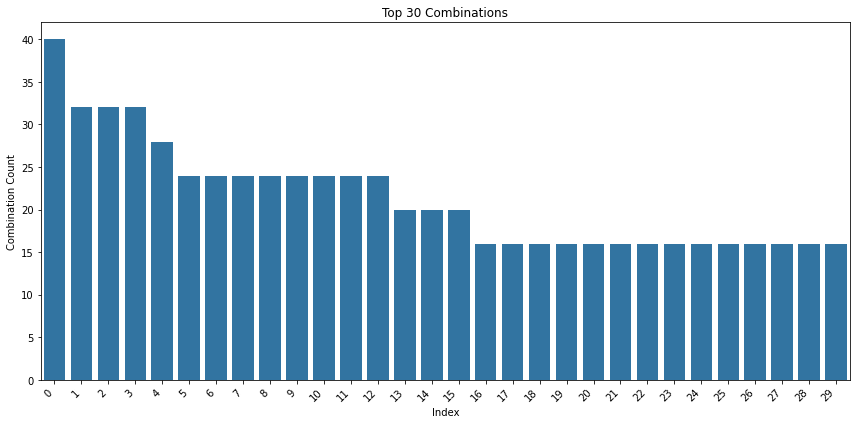

In [32]:
# Reset index to make plotting easier
plot_data = combination_2.head(30).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=plot_data.index, y=plot_data['CombinationCount'])
plt.title('Top 30 Combinations')
plt.xlabel('Index')
plt.ylabel('Combination Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Recommender 1 - SVD // Not Accurate

In [56]:
transactions

,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro
0,8119209481417068505,3532473209579560668,2023-06-06,4821951108133690356,4,56.97
1,2497726585282787281,5103640511191568912,2023-09-20,1450109522794525790,1,5.99
2,7673687066317773168,4923931302917549451,2023-12-16,1821464542701843363,2,16.99
3,1873234305263900608,8502620308847538595,2023-01-31,2686511472610728845,4,140.97
4,3913817537779196185,8573693021421318503,2024-01-23,3600233866627167751,1,10.99
...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05,3306498059038628287,2,16.99
1177171,1691937543970001915,7039116905723644150,2023-11-12,3306498059038628287,1,5.99
1177172,1003100987571803008,242506609152720728,2024-09-25,9099531021898466037,1,29.99
1177173,5201324372064592752,412909163137289630,2025-01-22,7913334853958149044,2,29.99


In [57]:
# Load data into Surprise's format
reader = Reader(rating_scale=(1, transactions['SalesNetAmountEuro'].max()))
data = Dataset.load_from_df(transactions[['ClientID', 'ProductID', 'SalesNetAmountEuro']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the SVD model
model = SVD()
model.fit(trainset)

# Function to suggest products for a specific ClientID
def suggest_products(client_id, model, transactions, top_n=5):
    # Get all unique products in the dataset
    all_products = transactions['ProductID'].unique()
    
    # Get the products that the client has already purchased
    purchased_products = transactions[transactions['ClientID'] == client_id]['ProductID'].values
    
    # Filter out products the client has already purchased
    products_to_predict = [p for p in all_products if p not in purchased_products]
    
    # Predict ratings for all the products that the client has not yet purchased
    predictions = [model.predict(client_id, product) for product in products_to_predict]
    
    # Sort predictions by estimated rating (preference score) in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Get the top N products
    top_predictions = predictions[:top_n]
    
    # Get the product IDs of the recommended products
    recommended_product_ids = [pred.iid for pred in top_predictions]
    
    return recommended_product_ids


In [58]:
clients.head()

,ClientID,ClientSegment,ClientCountry,ClientOptINEmail,ClientOptINPhone,ClientGender,Age
0,4508698145640552159,LOYAL,USA,1,1,M,NaN
1,2022746661324934183,INACTIVE_1Y,USA,0,1,F,NaN
2,5794452591674300222,LOYAL,USA,1,1,F,NaN
3,678556389231830160,LOYAL,USA,1,1,M,NaN
4,877301557964624234,LOYAL,USA,1,1,F,NaN


In [108]:
def fetch_product(product_IDs):
    if isinstance(product_IDs, (list, tuple)):
        return [fetch_single_product(pid) for pid in product_IDs]
    else:
        return fetch_single_product(product_IDs)

def fetch_single_product(product_ID):
    # Filter the DataFrame for the given ProductID
    product_info = products[products['ProductID'] == product_ID]

    # Check if the ProductID exists in the DataFrame
    if product_info.empty:
        return ("ProductID not found",)

    # Extract the relevant information
    category = product_info['Category'].values[0]
    family_level1 = product_info['FamilyLevel1'].values[0]
    family_level2 = product_info['FamilyLevel2'].values[0]

    # Return the information as a tuple
    return (category, family_level1, family_level2)


In [60]:
# Example: Get product suggestions for ClientID = 1
client_id = 8119209481417068505
recommended_products = suggest_products(client_id, model, transactions, top_n=5)
rec_prod=[]

for i in recommended_products:
    print(products[products['ProductID']==i]['Category'].values[0], end=' ')
    print(products[products['ProductID']==i]['FamilyLevel1'].values[0], end=' ')
    print(products[products['ProductID']==i]['FamilyLevel2'].values[0])


Beach Swimsuit Speedo Fastskin LZR Racer X
Baseball Bat Rawlings Quatro Pro
Cycling Bike Specialized S-Works Roubaix
Football Shoes Adidas Predator
Handball Shoes Asics Gel-Blast


## Recommender 2 - Confidence and Lift // TODO

In [ ]:
transactions.columns

Index(['ClientID', 'ProductID', 'SaleTransactionDate', 'StoreID', 'Quantity',
       'SalesNetAmountEuro'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.sparse import csr_matrix
import gc

def create_sparse_basket_matrix(df, batch_size=100000):
    """
    Creates a sparse basket matrix using batched processing to handle large datasets.

    Parameters:
    df (pandas.DataFrame): DataFrame with transaction data
    batch_size (int): Number of transactions to process in each batch

    Returns:
    sparse matrix: Sparse representation of basket data
    list: Product IDs
    list: Client IDs
    """
    # Get unique IDs
    unique_products = sorted(df['ProductID'].unique())
    unique_clients = sorted(df['ClientID'].unique())

    # Create ID mappings
    product_to_idx = {pid: idx for idx, pid in enumerate(unique_products)}
    client_to_idx = {cid: idx for idx, cid in enumerate(unique_clients)}

    # Initialize lists for sparse matrix construction
    rows = []
    cols = []
    data = []

    # Process in batches
    for start_idx in range(0, len(df), batch_size):
        batch = df.iloc[start_idx:start_idx + batch_size]

        # Create sparse matrix entries for this batch
        batch_rows = [client_to_idx[cid] for cid in batch['ClientID']]
        batch_cols = [product_to_idx[pid] for pid in batch['ProductID']]
        batch_data = [1] * len(batch_rows)  # Or use batch['Quantity'] if needed

        rows.extend(batch_rows)
        cols.extend(batch_cols)
        data.extend(batch_data)

        # Force garbage collection
        gc.collect()

    # Create sparse matrix
    basket_matrix = csr_matrix((data, (rows, cols)),
                               shape=(len(unique_clients), len(unique_products)))

    return basket_matrix, unique_products, unique_clients

def create_product_recommender(df, min_support=0.005, min_confidence=0.2, batch_size=100000):
    """
    Creates a product recommender system using association rules with memory-efficient processing.

    Parameters:
    df (pandas.DataFrame): DataFrame with columns ['ClientID', 'ProductID', 'SaleTransactionDate', 
                          'StoreID', 'Quantity', 'SalesNetAmountEuro']
    min_support (float): Minimum support threshold for apriori algorithm
    min_confidence (float): Minimum confidence threshold for rules
    batch_size (int): Number of transactions to process in each batch

    Returns:
    tuple: (frequent_itemsets, rules, product_list)
    """
    # Convert date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['SaleTransactionDate']):
        df['SaleTransactionDate'] = pd.to_datetime(df['SaleTransactionDate'])

    # Check if the dataset has valid transactions
    print("Checking for invalid transactions...")
    invalid_transactions = df[df['Quantity'] <= 0]
    print(f"Number of invalid transactions (Quantity <= 0): {invalid_transactions.shape[0]}")

    # Create sparse basket matrix
    print("Creating sparse basket matrix...")
    basket_matrix, products, clients = create_sparse_basket_matrix(df, batch_size)

    # Check if the matrix has non-zero entries
    print(f"Shape of the sparse basket matrix: {basket_matrix.shape}")
    print(f"Number of non-zero entries: {basket_matrix.nnz}")
    
    if basket_matrix.nnz == 0:
        raise ValueError("Basket matrix has no non-zero entries, check the dataset.")

    # Convert sparse matrix to dense format for mlxtend
    print("Converting sparse matrix to dense format for apriori...")
    basket_dense = pd.DataFrame(basket_matrix.toarray() > 0, columns=products)

    # Check if dense matrix is non-empty
    print(f"Shape of the dense basket matrix: {basket_dense.shape}")
    print("Preview of dense basket matrix:\n", basket_dense.head())

    # Generate frequent itemsets
    print("Generating frequent itemsets using apriori...")
    frequent_itemsets = apriori(basket_dense,
                               min_support=min_support,
                               use_colnames=True)

    print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
    
    if frequent_itemsets.empty:
        raise ValueError("No frequent itemsets found. Try adjusting the min_support.")

    # Generate association rules
    print("Generating association rules...")
    rules = association_rules(frequent_itemsets,
                            metric="confidence",
                            min_threshold=min_confidence)

    print(f"Number of association rules: {len(rules)}")
    
    # Sort rules by lift
    rules = rules.sort_values('lift', ascending=False)

    return frequent_itemsets, rules, products

def get_product_recommendations(rules_df, product_id, n_recommendations=5):
    """
    Get product recommendations based on a specific product.

    Parameters:
    rules_df (pandas.DataFrame): Association rules DataFrame
    product_id: The product ID to get recommendations for
    n_recommendations (int): Number of recommendations to return

    Returns:
    pandas.DataFrame: Top N recommended products with their confidence and lift scores
    """
    # Filter rules for the given product
    mask = rules_df['antecedents'].apply(lambda x: product_id in x)
    product_rules = rules_df[mask]

    if product_rules.empty:
        return pd.DataFrame()

    # Extract single items from consequents
    recommendations = []
    for _, row in product_rules.iterrows():
        for item in row['consequents']:
            recommendations.append({
                'recommended_product': item,
                'confidence': row['confidence'],
                'lift': row['lift']
            })

    recommendations_df = pd.DataFrame(recommendations)

    # Remove duplicates and sort by lift
    if not recommendations_df.empty:
        recommendations_df = (recommendations_df
                            .sort_values('lift', ascending=False)
                            .drop_duplicates('recommended_product')
                            .head(n_recommendations))

    return recommendations_df

# Example usage:
# Assuming 'transactions' is your DataFrame

min_support = 0.005  # Lowered min support for more frequent itemsets
min_confidence = 0.1  # Lowered min confidence for more rules
batch_size = 100000

print("Creating recommender...")
frequent_itemsets, rules, products = create_product_recommender(transactions,
                                                                min_support=min_support,
                                                                min_confidence=min_confidence,
                                                                batch_size=batch_size)

# Example: Get product recommendations for a specific product
product_id = 2203331223924251032  # Replace with a valid product ID from your data
recommendations = get_product_recommendations(rules, product_id, n_recommendations=5)
print("Top recommendations:", recommendations)

Creating recommender...
Checking for invalid transactions...
Number of invalid transactions (Quantity <= 0): 0
Creating sparse basket matrix...
Shape of the sparse basket matrix: (304929, 29730)
Number of non-zero entries: 976274
Converting sparse matrix to dense format for apriori...
Shape of the dense basket matrix: (304929, 29730)
Preview of dense basket matrix:
    72931364288678       513428984548409      793119236319256      \
0                False                False                False   
1                False                False                False   
2                False                False                False   
3                False                False                False   
4                False                False                False   

   1131439573284587     1406428649545374     2045483876403351     \
0                False                False                False   
1                False                False                False   
2                F

## Recommender 3 - time-series recommendation //  DONE

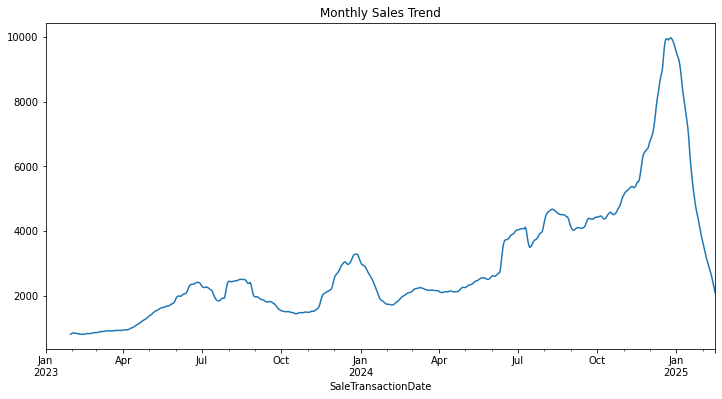

In [62]:
import matplotlib.pyplot as plt

# Aggregate sales over time
transactions['SaleTransactionDate'] = pd.to_datetime(transactions['SaleTransactionDate'])
transactions_time_series = transactions.groupby(['SaleTransactionDate'])['Quantity'].sum()

# Plot trends
transactions_time_series.rolling(window=30).mean().plot(figsize=(12,6))
plt.title('Monthly Sales Trend')
plt.show()

In [87]:
def top_sold_products(n, transactions, start_date, end_date):
    """
    Identify the top 5 most sold products during a given date range.
    
    Parameters:
        transactions (DataFrame): The transactions data containing 'SaleTransactionDate', 'ProductID', and 'Quantity'.
        start_date (str): Start date of the peak period (format: 'YYYY-MM-DD').
        end_date (str): End date of the peak period (format: 'YYYY-MM-DD').
    
    Returns:
        DataFrame: Top 5 most sold products with their total quantity sold.
    """
    # Ensure the 'SaleTransactionDate' column is in datetime format
    transactions['SaleTransactionDate'] = pd.to_datetime(transactions['SaleTransactionDate'])
    
    # Filter transactions within the specified date range
    peak_period_transactions = transactions[
        (transactions['SaleTransactionDate'] >= start_date) & 
        (transactions['SaleTransactionDate'] <= end_date)
    ]
    
    # Group by 'ProductID' and sum the quantities
    product_sales = peak_period_transactions.groupby('ProductID')['Quantity'].sum()
    
    # Sort by quantity in descending order and get the top 5 products
    top_products = product_sales.sort_values(ascending=False).head(n)
    
    return top_products.reset_index()


In [90]:
# Example usage
# Define the date range for the peak period
start_date = '2024-10-01'
end_date = '2025-01-31'

# Assuming 'transactions' is your DataFrame
top_products_during_peak = top_sold_products(3, transactions, start_date, end_date)
top_products_during_peak['ProductID'] = top_products_during_peak['ProductID'].apply(lambda x: fetch_product(x))
top_products_during_peak


,ProductID,Quantity
0,Football Shorts Nike Dri-FIT,5763
1,Basketball Ball Spalding NBA Official Game Ball,5709
2,Football Jersey Puma Third Jersey,5699


## Recommender 4 - Store-wide Recommendation // DONE

In [95]:
df_store = transactions.groupby(['StoreID', 'ProductID'])['Quantity'].sum().reset_index()
top_products_per_store = df_store.groupby('StoreID').apply(lambda x: x.nlargest(5, 'Quantity'), include_groups=False)

top_products_per_store['ProductID'] = top_products_per_store['ProductID'].apply(lambda x: fetch_product(x))

(top_products_per_store)

ProductID  \
StoreID                                                                       
85129655194753350   2914    Basketball Ball Spalding NBA Official Game Ball   
                    1175    Basketball Ball Spalding NBA Official Game Ball   
                    1347        Basketball Ball Wilson Evolution Basketball   
                    1290                       Football Shorts Nike Dri-FIT   
                    2013                   Tennis Racket Babolat Pure Drive   
...                                                                     ...   
9099531021898466037 321468                Football Jersey Puma Third Jersey   
                    321551                       Tennis Ball Wilson US Open   
                    320387                       Football Shoes Puma Future   
                    320027                       Football Ball Nike Ordem V   
                    320571                    Tennis Ball Penn Championship   

                            Quantity  
StoreID                               
85129655194753350   2914         170  
                    1175         118  
                    1347         105  
                    1290          87  
                    2013          87  
...                              ...  
9099531021898466037 321468       175  
                    321551       112  
                    320387       109  
                    320027       105  
                    320571        95  

[752 rows x 2 columns]